# PINN for an Elliptic PDE on the Unit Sphere

This notebook implements the Physics-Informed Neural Network (PINN) method from  
Tang and Fu (2021), [“Physics-informed Neural Networks for Elliptic Partial Differential Equations on 3D Manifolds”](https://arxiv.org/pdf/2103.02811),  
specialised to their unit sphere test case.

We solve
$
(a \Delta_S - \mathbf b \cdot \nabla_S + c)\,u(x,y,z) = f(x,y,z), \
$
$
\qquad (x,y,z) \in S^2,
$

on
$
S^2 = \{(x,y,z) \in \mathbb{R}^3 : x^2 + y^2 + z^2 = 1\}.
$

Parameters:
- $a = 1$
- $\mathbf b = (1,1,1)^{\mathsf T}$
- $c = 5$

Exact solution:
$
u_{\mathrm{exact}}(x,y,z) = \sin(x)\,\sin(y)\,\sin(z).
$

In this notebook we

1. use the explicit Cartesian formula for the Laplace–Beltrami operator $\Delta_S$ on the unit sphere,
2. approximate the solution by a neural network $u_\theta(x,y,z)$ taking Cartesian coordinates on $S^2$ as input,
3. define the PINN loss
   
   $\mathcal{L}(\theta) = \frac{1}{N}\sum_{k=1}^N \left[ (a \Delta_S - \mathbf b \cdot \nabla_S + c)\,u_\theta(x_k) - f(x_k) \right]^2,$
   evaluated at collocation points $x_k \in S^2$,
4. train the network to minimise this loss and compare $u_\theta$ with $u_{\mathrm{exact}}$ on random test points on the sphere.


In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import math
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


# Geometry, exact solution, and differential operators

This cell sets up the pieces needed to define the PDE on the unit sphere.

- sample_sphere samples approximately uniform points on the unit sphere by drawing Gaussian vectors and normalising them.

- u_exact implements the manufactured solution  
  $u_{\text{exact}}(x,y,z) = \sin(x)\sin(y)\sin(z)$  
  and returns its values at input points $X = (x,y,z)$.

- a, b_vec and c set the PDE coefficients to match the paper: $a = 1$, $\mathbf b = (1,1,1)^{\mathsf T}$, $c = 5$.

- compute_grad_and_hessian uses automatic differentiation to obtain the Euclidean gradient  
  and Hessian of a scalar field $u(x,y,z)$ with respect to $(x,y,z)$.

- sphere_laplace_beltrami implements the explicit Laplace–Beltrami formula on the unit sphere  
  (equation (8) in the paper):
  $\Delta_S u = (1-x^2)\partial_{xx} u + (1-y^2)\partial_{yy} u + (1-z^2)\partial_{zz} u
               - 2xy\,\partial_{xy} u - 2xz\,\partial_{xz} u - 2yz\,\partial_{yz} u
               - 2x\,\partial_x u - 2y\,\partial_y u - 2z\,\partial_z u$  
  using the gradient and Hessian from compute_grad_and_hessian.


- surface_gradient computes the surface gradient via the projection formula  
  $\nabla_S u = \nabla u - (\nabla u \cdot n)\,n$ with $n = (x,y,z)$ on the unit sphere.

- compute_f_on_points applies the full operator  
  $(a \Delta_S - \mathbf b \cdot \nabla_S + c)$  
  to $u_{\text{exact}}$ at given points and returns  
  $f(x) = (a \Delta_S - \mathbf b \cdot \nabla_S + c)u_{\text{exact}}(x)$,  
  which is the right-hand side used in the PINN training.


In [ ]:
# Geometry: unit sphere and sampling 

def sample_sphere(n_points, rng=None):
    '''
    Sample points quasi-uniformly on the unit sphere using normal vectors.
    '''
    if rng is None:
        rng = np.random.default_rng()
    # Sample from normal distribution and normalize
    xyz = rng.normal(size=(n_points, 3))
    norms = np.linalg.norm(xyz, axis=1, keepdims=True)
    xyz /= norms
    return xyz.astype(np.float32)

# Exact solution u_exact and its PDE operator 

def u_exact(X):
    '''
    Exact solution u(x,y,z) = sin(x) sin(y) sin(z).
    X: tensor of shape (N,3) with columns x,y,z.
    Returns tensor of shape (N,1).
    '''
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    u = torch.sin(x) * torch.sin(y) * torch.sin(z)
    return u.unsqueeze(1)

# PDE parameters
a = 1.0
b_vec = torch.tensor([1.0, 1.0, 1.0])  # (b1,b2,b3)
c = 5.0

def compute_grad_and_hessian(u, X):
    '''
    Compute gradient and Hessian of u with respect to X.

    u: tensor (N,1), X: tensor (N,3) with requires_grad=True.

    Returns:
        grads: tensor (N,3) = [u_x, u_y, u_z]
        H: tensor (N,3,3) where H[i] is the Hessian at point i.
    '''
    N = X.shape[0]
    # First derivatives
    grads = autograd.grad(
        outputs=u,
        inputs=X,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]  # (N,3)

    H = torch.zeros(N, 3, 3, device=X.device, dtype=X.dtype)
    for i in range(3):
        g_i = grads[:, i].unsqueeze(1)  # (N,1)
        grad2 = autograd.grad(
            outputs=g_i,
            inputs=X,
            grad_outputs=torch.ones_like(g_i),
            create_graph=True,
            retain_graph=True
        )[0]  # (N,3)
        H[:, i, :] = grad2
    return grads, H

def sphere_laplace_beltrami(X, u, grads, H):
    '''
    Compute Laplace-Beltrami Delta_S u on the unit sphere using the explicit formula:
    Delta_S u = (1 - x^2) u_xx + (1 - y^2) u_yy + (1 - z^2) u_zz
                - 2xy u_xy - 2xz u_xz - 2yz u_yz
                - 2x u_x - 2y u_y - 2z u_z
    '''
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]

    u_x = grads[:, 0]
    u_y = grads[:, 1]
    u_z = grads[:, 2]

    u_xx = H[:, 0, 0]
    u_xy = H[:, 0, 1]
    u_xz = H[:, 0, 2]
    u_yx = H[:, 1, 0]
    u_yy = H[:, 1, 1]
    u_yz = H[:, 1, 2]
    u_zx = H[:, 2, 0]
    u_zy = H[:, 2, 1]
    u_zz = H[:, 2, 2]

    # Symmetrize mixed second derivatives 
    u_xy = 0.5 * (u_xy + u_yx)
    u_xz = 0.5 * (u_xz + u_zx)
    u_yz = 0.5 * (u_yz + u_zy)

    lap_s = ((1 - x**2) * u_xx +
             (1 - y**2) * u_yy +
             (1 - z**2) * u_zz
             - 2 * x * y * u_xy
             - 2 * x * z * u_xz
             - 2 * y * z * u_yz
             - 2 * x * u_x
             - 2 * y * u_y
             - 2 * z * u_z)
    return lap_s.unsqueeze(1)

def surface_gradient(X, grads):
    '''
    Compute surface gradient on unit sphere:
    grad_S u = grad u - (grad u · n) n, where n = (x,y,z).
    '''
    n = X  # since on unit sphere, n = (x,y,z)
    dot = (grads * n).sum(dim=1, keepdim=True)  # (N,1)
    grad_s = grads - dot * n
    return grad_s  # (N,3)

def compute_f_on_points(X_np):
    '''
    Compute f(x) = (a Delta_S - b·grad_S + c) u_exact(x)
    on a set of points X_np (numpy array, shape (N,3)).
    '''
    X = torch.tensor(X_np, device=device, dtype=torch.float32, requires_grad=True)
    u = u_exact(X)
    grads, H = compute_grad_and_hessian(u, X)
    lap_s = sphere_laplace_beltrami(X, u, grads, H)
    grad_s = surface_gradient(X, grads)
    # b · grad_S u
    b = b_vec.to(device).view(1, 3)
    adv = (grad_s * b).sum(dim=1, keepdim=True)
    L_u = a * lap_s - adv + c * u
    f_vals = L_u.detach().cpu().numpy()
    return f_vals


# PINN model and PDE residual

This cell defines the neural network used as the PINN and the function that evaluates the PDE residual.

The class PINN is a fully connected feedforward network mapping Cartesian coordinates on the sphere to a scalar:

- input dimension in_dim = 3 for coordinates (x, y, z) on S^2
- output dimension out_dim = 1 for the scalar field u(x, y, z)
- hidden_layers and hidden_dim control depth and width
- nn.Tanh applies the nonlinearity tanh after each hidden layer

The network therefore represents a parametric function u_θ(x, y, z) that approximates the solution u.

The function pde_residual evaluates the operator
$(a \Delta_S - \mathbf b \cdot \nabla_S + c)\,u_\theta(x, y, z) - f(x, y, z)$
at collocation points X:

- u = model(X) gives u_θ at those points
- compute_grad_and_hessian returns the Euclidean gradient and Hessian of u_θ with respect to (x, y, z)
- sphere_laplace_beltrami uses these derivatives to compute the Laplace–Beltrami term Δ_S u_θ on the unit sphere
- surface_gradient computes the surface gradient ∇_S u_θ
- the dot product with b_vec gives the advection term b · ∇_S u_θ
- combining these pieces gives the residual (a Δ_S − b · ∇_S + c) u_θ − f at each point

In training, the PINN loss is the mean squared residual over all collocation points, as in section 2.2 of the paper.



In [ ]:
# PINN model 

class PINN(nn.Module):
    def __init__(self, in_dim=3, out_dim=1, hidden_layers=4, hidden_dim=64, activation=nn.Tanh):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * hidden_layers + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(activation())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

def pde_residual(model, X, f_target):
    '''
    Compute PDE residual (a Delta_S - b·grad_S + c) u_theta - f on points X.

    model: PINN
    X: tensor (N,3) with requires_grad=True
    f_target: tensor (N,1), precomputed exact f values
    '''
    u = model(X)  # (N,1)
    grads, H = compute_grad_and_hessian(u, X)
    lap_s = sphere_laplace_beltrami(X, u, grads, H)  # (N,1)
    grad_s = surface_gradient(X, grads)  # (N,3)
    b = b_vec.to(X.device).view(1, 3)
    adv = (grad_s * b).sum(dim=1, keepdim=True)  # (N,1)
    residual = a * lap_s - adv + c * u - f_target
    return residual


# Sanity check

This cell checks that the manufactured exact solution really satisfies the PDE as implemented.

- sample_sphere generates 2000 random points X_check_np on the unit sphere and these are moved to a tensor X_check with gradients enabled.

- u = u_exact(X_check) evaluates the exact solution u_exact at those points.

- f is computed at the same points using compute_f_on_points, which applies the operator (a Δ_S − b · ∇_S + c) to u_exact:
  f(x) = (a Δ_S − b · ∇_S + c) u_exact(x).

- compute_grad_and_hessian, sphere_laplace_beltrami and surface_gradient are then used to recompute
  L_u = (a Δ_S − b · ∇_S + c) u
  directly from u on X_check.

- res_exact = L_u − f is the pointwise residual of the PDE for the exact solution.

- The printed RMS residual and maximum absolute residual should be numerically very close to zero, confirming that the PDE operator and the right-hand side f are consistent.


In [ ]:
# Sanity check 

# sample some random points on the sphere
X_check_np = sample_sphere(2000)
X_check = torch.tensor(X_check_np, device=device,
                       dtype=torch.float32, requires_grad=True)

# exact solution at those points
u = u_exact(X_check)

# compute f from our helper 
f = torch.tensor(compute_f_on_points(X_check_np),
                 device=device, dtype=torch.float32)

# compute operator (a Δ_S - b·∇_S + c) u at the same points
grads, H = compute_grad_and_hessian(u, X_check)
lap_s = sphere_laplace_beltrami(X_check, u, grads, H)
grad_s = surface_gradient(X_check, grads)
b = b_vec.to(device).view(1, 3)
adv = (grad_s * b).sum(dim=1, keepdim=True)
L_u = a * lap_s - adv + c * u

# residual for the exact solution
res_exact = L_u - f

print("RMS residual for u_exact:", torch.sqrt(torch.mean(res_exact**2)).item())
print("Max |residual| for u_exact:", torch.max(torch.abs(res_exact)).item())


RMS residual for u_exact: 0.0
Max |residual| for u_exact: 0.0


# Training data and optimization

This cell prepares the data on the sphere, initializes the PINN, and trains it.

- rng, N_train and N_test set the random seed and the number of training and test points on the unit sphere. sample_sphere builds X_train_np and X_test_np.

- compute_f_on_points evaluates the PDE operator
  (a Δ_S − b · ∇_S + c) u_exact
  on these points to produce f_train_np and f_test_np. These arrays are converted to tensors X_train, X_test, f_train, f_test. X_train has requires_grad=True so autograd can compute derivatives.

- A PINN model is created and moved to the chosen device. Adam with learning rate 1e−3 is used for the first optimization stage.

- In each epoch, pde_residual(model, X_train, f_train) computes the residual
  (a Δ_S − b · ∇_S + c) u_θ − f
  at the training points. The loss is the mean of the squared residuals, and backpropagation updates the network parameters.

- If use_lbfgs is True, an additional L-BFGS stage is run using the closure function. This usually refines the solution found by Adam by further reducing the residual.


In [ ]:
# Generate training and test data 

rng = np.random.default_rng(12345)
N_train = 1500
N_test = 2500

X_train_np = sample_sphere(N_train, rng)
X_test_np = sample_sphere(N_test, rng)

# Compute f on training and test points using the exact solution
print("Computing f on training points...")
f_train_np = compute_f_on_points(X_train_np)
print("Computing f on test points...")
f_test_np = compute_f_on_points(X_test_np)

X_train = torch.tensor(X_train_np, device=device, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test_np, device=device, dtype=torch.float32)
f_train = torch.tensor(f_train_np, device=device, dtype=torch.float32)
f_test = torch.tensor(f_test_np, device=device, dtype=torch.float32)

# Initialize model and optimizer 

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Optional L-BFGS refinement
use_lbfgs = True

# Training 

num_epochs = 2000
print_every = 100

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    res = pde_residual(model, X_train, f_train)
    loss = torch.mean(res**2)
    loss.backward()
    optimizer.step()

    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | Loss = {loss.item():.4e}")

print("Training with Adam finished.")

if use_lbfgs:
    print("Refining with L-BFGS...")
    def closure():
        optimizer_lbfgs.zero_grad()
        res = pde_residual(model, X_train, f_train)
        loss = torch.mean(res**2)
        loss.backward()
        return loss

    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, history_size=50)
    optimizer_lbfgs.step(closure)
    print("L-BFGS refinement finished.")


Computing f on training points...
Computing f on test points...
Epoch     1 | Loss = 4.0763e-01
Epoch   100 | Loss = 4.3138e-03
Epoch   200 | Loss = 1.9498e-03
Epoch   300 | Loss = 1.0248e-03
Epoch   400 | Loss = 6.9052e-04
Epoch   500 | Loss = 4.7745e-04
Epoch   600 | Loss = 3.4139e-04
Epoch   700 | Loss = 3.1066e-04
Epoch   800 | Loss = 2.1756e-04
Epoch   900 | Loss = 1.7364e-04
Epoch  1000 | Loss = 1.4124e-04
Epoch  1100 | Loss = 3.6659e-04
Epoch  1200 | Loss = 1.1589e-04
Epoch  1300 | Loss = 1.0093e-04
Epoch  1400 | Loss = 1.1333e-04
Epoch  1500 | Loss = 9.3438e-05
Epoch  1600 | Loss = 8.2662e-05
Epoch  1700 | Loss = 7.4382e-05
Epoch  1800 | Loss = 4.1522e-04
Epoch  1900 | Loss = 7.3677e-05
Epoch  2000 | Loss = 6.6073e-05
Training with Adam finished.
Refining with L-BFGS...
L-BFGS refinement finished.


# Evaluation on test points

This cell evaluates the trained PINN on independent test points on the sphere.

- model.eval() and torch.no_grad() switch the network to evaluation mode and disable gradient tracking. u_pred and u_true are the predicted and exact values of u on X_test.

- The relative L2 error is computed as
  $
  \text{rel\_L2}
  = \frac{\sqrt{\mathbb{E}\big[(u_{\text{pred}} - u_{\text{true}})^2\big]}}
         {\sqrt{\mathbb{E}\big[u_{\text{true}}^2\big]}}.
  $
  This gives a scale-free measure of how close the PINN solution is to the exact solution on the sphere.

- The scatter plot shows the pointwise error u_pred − u_true versus the x-coordinate of the test points. It provides a quick visual check for any systematic bias or spatial pattern in the error on the unit sphere.


Relative L2 error on test points: 5.0084e-03


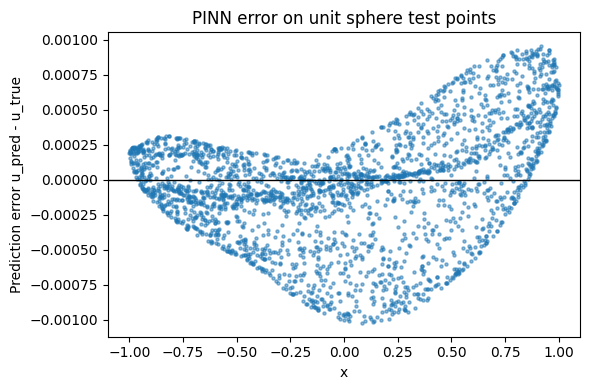

In [ ]:
# Evaluation on test points 

model.eval()
with torch.no_grad():
    u_pred = model(X_test).cpu().numpy()  # (N_test,1)
    u_true = u_exact(X_test).cpu().numpy()  # (N_test,1)

# Compute relative L2 error
num = np.sqrt(np.mean((u_pred - u_true)**2))
den = np.sqrt(np.mean(u_true**2))
rel_l2 = num / den
print(f"Relative L2 error on test points: {rel_l2:.4e}")

# Simple scatter plot of error vs. x-coordinate (just for a rough visual)
err = (u_pred - u_true).flatten()
plt.figure(figsize=(6,4))
plt.scatter(X_test_np[:,0], err, s=5, alpha=0.5) 
plt.axhline(0.0, color='k', linewidth=1)
plt.xlabel('x')
plt.ylabel('Prediction error u_pred - u_true')
plt.title('PINN error on unit sphere test points')
plt.tight_layout()
plt.show()
